


# Getting started with machine learning and deep learning on Google Colab

## 0. setting up for Tensorflow

You have successfully opened this notebook in Colab. The nice thing about Colab is that most things are already installed. However, there are a few things you still need to do. The first is to make sure you are using the right version of Tensorflow: you need 2.0 but at the moment of writing this notebook, this is not the default version yet. In order to fix this, run the code below:

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

The second thing is doing some standard (and some less standard) imports:

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

print(tf.__version__)

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)

2.1.0


## 1. Steps in machine learning

In class we identified the following important steps in machine learning:

1. Problem and data analysis
2. Train/validate/test split
3. Preprocessing and feature extraction
4. Model training and hyperparameter tuning
5. Analysis of performance and errors

Steps 1 and 3 are usually very specific to the problem and the dataset, so we will not address them here. What we will provide are examples for the most common operations in steps 2, 4 and 5 when working with Keras. Note that it is common to Python that there are usually many ways in which to do things. From that perspective, what we show below is only one example and you may find others online.

## 2. Setting up and splitting the data

The first thing you need to do in any supervised machine learning problem is importing the data. As is always the case in Python, there are many ways to to this, which depend on the specific data you are using. For educational purposes, some simple datasets are provided with either Scikit-Learn (sklearn - https://scikit-learn.org/stable/) or Tensorflow. For these datasets, there are built-in functions to import them. Many other datasets are provided as .csv files, which are most easily imported with Pandas (https://pandas.pydata.org). For more complex datasets, you may possibly have to write your own importing functions.

Once the data is imported, you can start analysing it, which includes visualising and extracting statistics. This should give you insight into good preprocessing, data cleaning and feature extraction steps, eventually resulting in the features you will use in your model.

In this example we will use two built-in datasets, one for regression and one for classification. We start with the regression data set and address specific changes for classification data sets at the end of this notebook.

The data set is the Boston house prices data set that was also discussed in class. You can load it as follows:



In [3]:
boston_housing = keras.datasets.boston_housing

(all_train_data, all_train_labels), (X_test, r_test) = boston_housing.load_data()

# Shuffle the training set
order = np.argsort(np.random.random(all_train_labels.shape))
all_train_data = all_train_data[order]
all_train_labels = all_train_labels[order]

print("Training set: {}".format(all_train_data.shape))  # 404 examples, 13 features
print("Test set:  {}".format(X_test.shape))   # 102 examples, 13 features


Training set: (404, 13)
Test set:  (102, 13)


The data is stored with a fixed test set, so we do not need to split this off. We do, however, need to split off at least one validation set. 

In [4]:
from sklearn.model_selection import train_test_split



val_fraction = 0.25
X_train, X_val, r_train, r_val = train_test_split(all_train_data, all_train_labels, 
                                                    test_size = val_fraction, 
                                                    random_state=0)

print("Training set: {}".format(X_train.shape)) 
print("Validation set:  {}".format(X_val.shape))   
print("Test set:  {}".format(X_test.shape))   



Training set: (303, 13)
Validation set:  (101, 13)
Test set:  (102, 13)


The dataset contains 13 different features:

1.   Per capita crime rate.
2.   The proportion of residential land zoned for lots over 25,000 square feet.
3.   The proportion of non-retail business acres per town.
4.   Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5.   Nitric oxides concentration (parts per 10 million).
6.   The average number of rooms per dwelling.
7.   The proportion of owner-occupied units built before 1940.
8.   Weighted distances to five Boston employment centers.
9.   Index of accessibility to radial highways.
10.  Full-value property-tax rate per $10,000.
11.  Pupil-teacher ratio by town.
12.  1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13.  Percentage lower status of the population.

Each one of these input data features is stored using a different scale. Some features are represented by a proportion between 0 and 1, other features are ranges between 1 and 12, some are ranges between 0 and 100, and so on. 



In [5]:
print(X_train[0])  # First training sample, not normalized

[6.8600e-02 0.0000e+00 2.8900e+00 0.0000e+00 4.4500e-01 7.4160e+00
 6.2500e+01 3.4952e+00 2.0000e+00 2.7600e+02 1.8000e+01 3.9690e+02
 6.1900e+00]


As seen in class, it is advised to normalise these data first. The easiest way to do this is to use one of sklearn's 'scalers'. In this case, we will use the "StandardScaler". The parameters of the scaler, the mean to subtract and the stdev to divide by are 'fitted' first. In order to avoid information leakage, this fitting should happen ONLY on the trainind data:

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_s = scaler.transform(X_train)


# it is crucial to do the same transformations to the validation and test data
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

print(X_train_s[0])  # First training sample,  normalized

[-0.38953535 -0.49125861 -1.19447624 -0.23611253 -0.95479394  1.69508869
 -0.21544726 -0.13909219 -0.85238625 -0.78871756 -0.25078858  0.44875306
 -0.92551591]


We see that now, all features more or less have the smae scale and they are centered around zero. For now, this is all the preprocessing we will do.

## 2. Training a linear model

We haven't seen neural networks yet. However, it was mentioned that all but th elast layers of a neural network can also be considerered as a trained feature extractor. The features it extracts are the inputs to the last layer, which is nothing more than a linear model. For now, we will therefore omit the feature extraction layers and "abuse" Keras to train a linear model on top of the features in our data set.

The way Keras works is as follows:

1. Define the structure of your model
2. Compile it: this builds the computational graph to be used when calculating the model outputs as well as for gradient descent
3. Fit the model to the training data
4. Evaluate the model

Since we will be using linear regression, the model structure is fixed. It consists of one layer which connects all input features to the output. In Keras, such a layer is called a Dense layer. We will put the code for constructing the model and compiling it in a function wrapper. This way you can easily re-use it.



In [7]:

from tensorflow.keras import regularizers

def build_model(inp_shape, lr = 0.01,L2=0.0):
  # a model is always built up as a list of layers
  # In the first layer, you need to define the shape of the input
  # all other layers automatically use the shape of the previous layer's output
  # a linear model only has a single layer

  model = keras.Sequential([
    keras.layers.Dense(1, input_shape=(inp_shape,),
                       kernel_regularizer=regularizers.l2(L2))
  ])

  optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

  # When compiling the model, you have to tell it which training algorithm we will be using
  # Details about these are not relevant at this point
  # You also need to tell it which loss function it will be optimising 
  # and which alternative loss functions to keep track of
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model


The summary gives an overview of all layers in the model. It also shows the output shape of each layer and the number of trainable parameters it has. In this case, since we are doing linear regression with 13 features, the model has 14 parameters. 

Next, we build and train the model:

In [8]:
model = build_model(X_train_s.shape[1]) # call model for right number of features
model.summary()

EPOCHS = 30

# Store training stats per EPOCH in history to allow plotting afterwards
history = model.fit(X_train_s, r_train, epochs=EPOCHS,
                    validation_data=(X_val_s,r_val), verbose=0)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 14        
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


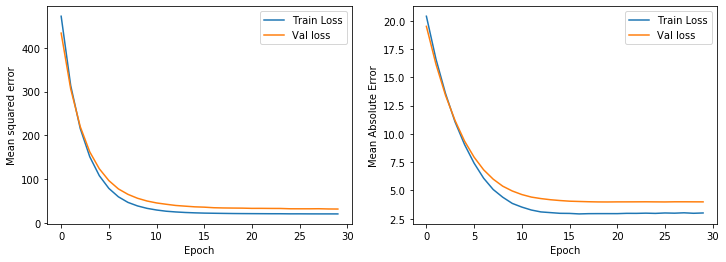

In [9]:
def plot_history(history):
  plt.figure(figsize = (12,4))
  plt.subplot(1,2,1)

  plt.xlabel('Epoch')
  plt.ylabel('Mean squared error')
  plt.plot(history.epoch, np.array(history.history['loss']), 
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error')
  plt.plot(history.epoch, np.array(history.history['mae']), 
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mae']),
           label = 'Val loss')
  plt.legend()
  
plot_history(history)

We see that the training has converged, i.e. there are no more improvements. There is very little overfitting because the model is really simple (low bias). Note that we did not (need to) do any regularisation here!


## 3. Model evaluation and data splitting issues

Now that the model is trained, we need to evalate it. We will first get the model outputs for train, validate and test sets, as well as all corresponding scores.

Training set Mean Squared Error:  20.42
Training set Mean Absolute Error:   3.01

Validation set Mean Squared Error:  31.74
Validation set Mean Absolute Error:   3.99

Test set Mean Squared Error:  21.08
Test set Mean Absolute Error:   3.29



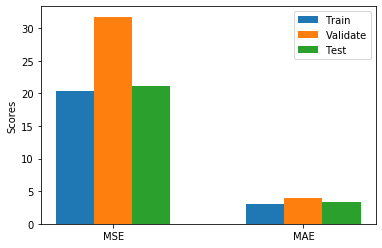

In [10]:
[train_loss, train_mae] = model.evaluate(X_train_s, r_train, verbose=0)
print("Training set Mean Squared Error:{:7.2f}".format(train_loss))
print("Training set Mean Absolute Error:{:7.2f}\n".format(train_mae))

[val_loss, val_mae] = model.evaluate(X_val_s, r_val, verbose=0)
print("Validation set Mean Squared Error:{:7.2f}".format(val_loss))
print("Validation set Mean Absolute Error:{:7.2f}\n".format(val_mae))

[test_loss, test_mae] = model.evaluate(X_test_s, r_test, verbose=0)
print("Test set Mean Squared Error:{:7.2f}".format(test_loss))
print("Test set Mean Absolute Error:{:7.2f}\n".format(test_mae))

# We'll make a nice plot to visualise this
# Note that this can be done a lot more elegantly, e.g. with Seaborn

train_values = [train_loss, train_mae]
val_values = [val_loss, val_mae]
test_values = [test_loss, test_mae]
labels = ['MSE', 'MAE']


x=np.arange(2)
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_values, width, label='Train')
rects2 = ax.bar(x , val_values, width, label='Validate')
rects3 = ax.bar(x + width, test_values, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
#ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

**A sidenote on how to iteratively improve your model:**

At this point, as a machine learner, you should have a clear expectation of what to expect. In this case, validation and test sets are approximately the same size, and the validation set has not been used yet to make any decisions about the model. In principle, the model should perform equally well on both. If the validation set has been used, test loss is usually a bit (but not much) worse than validation loss. Any deviations from this rule, in particularly unusually large gaps, can usually be related to problems with the data, the splitting of the data, or information leakage. 

**Checking whether your data splitting is reliable and whether your code does not contain information leakage is one of the only occasions where it is allowed to look at test scores during model optimisation.**

In this case, we observe something unexpected: the validation MSE is considerably worse than the test mse. The only reason for this can be that **the i.i.d. assumption is violated**. We can only assume that the train-test split was done without information leakage (it was done for us), and as far as we know, there was no information leakage in the train/validate split. This only leaves the assumption of the data being identically distributed. This could be due to the splitting not being doen randomly, leading to different feature or label distributions (can be checked by plotting histograms) of it could be caused by a small number of outliers. A second observation is that the difference between both sets is much smaller for MAE then for MSE. This refines our hypothesis of where the problem lies. MSE takes the square of the errors, which means that large errors are "blown up". We can assume that a few examples, possibly outliers or mislabeled samples, occur in the validation set but not in the test set.

At this point, having phrased a hypothesis of what is wrong, you should go back to the data: find the samples where your model makes the largest errors, decide if they are real outliers, or maybe mislabeled samples, and try to correct them or remove them from the data set. Then you validate your hypothesis by re-running the model and (hopefully) concluding that the problem is solved. If you do not solve this, then any more complex model with lots of hyperparameters will be tuned on a validation set that is not reliable.

Feel free to try and fix this problem. Possible actions are:
- plot histograms of the features and the labels in validation and test sets and compare them
- identify the validation and test samples with the largest errors
- decide whether either the features or the labels of the worst validation examples can be considered as outliers
- If there are really few outliers: remove them and see if the results become more stable

However, since preprocessing is not the core topic of this tutorial, we will switch to the main topic again.

## 4. Iterative model improvement

Since this tutorial is restricted to linear models, and we don't have enough background on the data to do proper domain-specific feature expansion, there is not a lot we can do. For this reason, we will only explore polynomial feature expansion here. Sklearn provides a function to do this:



In [11]:
from sklearn.preprocessing import PolynomialFeatures

# fitting this module only involves counting the number of features

polytf2 = PolynomialFeatures(degree=2,include_bias=False)

polytf2.fit(X_train)

X_train_p2 = polytf2.transform(X_train)
X_val_p2 = polytf2.transform(X_val)
X_test_p2 = polytf2.transform(X_test)

print(X_train_p2.shape)
print(X_val_p2.shape)
print(X_test_p2.shape)

# Before using them, we need to scale the transformed features
scaler2 = StandardScaler()
scaler2.fit(X_train_p2)

X_train_p2s = scaler2.transform(X_train_p2)
X_val_p2s = scaler2.transform(X_val_p2)
X_test_p2s = scaler2.transform(X_test_p2)



(303, 104)
(101, 104)
(102, 104)


As you can see, we have now expanded the original feature set to 104 new features. These include the 13 original features, the 13 squares of these, and the 78 unique cross products between original features. We will now again train a linear model and see what comes out.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 105       
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


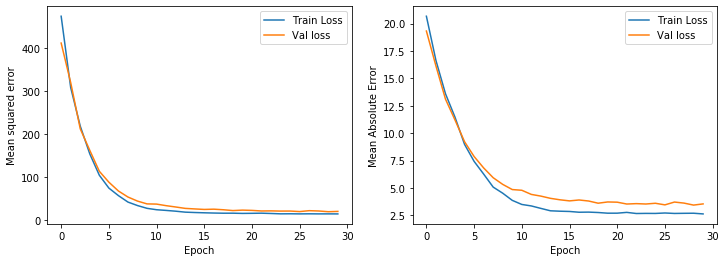

In [12]:
# call model for right number of features
# in addition, we need to decrease the learning rate in this case
# check for yourself what happens for larger learning rates
model_p2 = build_model(X_train_p2.shape[1])
model_p2.summary()

# Since the learning rate is a factor 10 smaller, we need more EPOCHs to cover the same ground
EPOCHS = 30

# Store training stats per EPOCH in history to allow plotting afterwards
history_p2 = model_p2.fit(X_train_p2s, r_train, epochs=EPOCHS,
                    validation_data=(X_val_p2s,r_val), verbose=0)
plot_history(history_p2)

Training set Mean Squared Error:  14.00
Training set Mean Absolute Error:   2.63

Validation set Mean Squared Error:  20.05
Validation set Mean Absolute Error:   3.54

Test set Mean Squared Error:  27.58
Test set Mean Absolute Error:   3.47



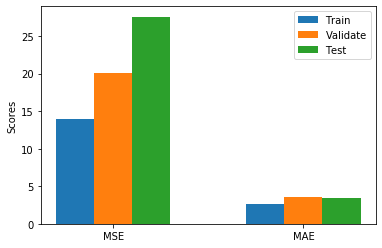

In [13]:
[train_loss_p2, train_mae_p2] = model_p2.evaluate(X_train_p2s, r_train, verbose=0)
print("Training set Mean Squared Error:{:7.2f}".format(train_loss_p2))
print("Training set Mean Absolute Error:{:7.2f}\n".format(train_mae_p2))

[val_loss_p2, val_mae_p2] = model_p2.evaluate(X_val_p2s, r_val, verbose=0)
print("Validation set Mean Squared Error:{:7.2f}".format(val_loss_p2))
print("Validation set Mean Absolute Error:{:7.2f}\n".format(val_mae_p2))

[test_loss_p2, test_mae_p2] = model_p2.evaluate(X_test_p2s, r_test, verbose=0)
print("Test set Mean Squared Error:{:7.2f}".format(test_loss_p2))
print("Test set Mean Absolute Error:{:7.2f}\n".format(test_mae_p2))

# We'll make a nice plot to visualise this
# Note that this can be done a lot more elegantly, e.g. with Seaborn

train_values = [train_loss_p2, train_mae_p2]
val_values = [val_loss_p2, val_mae_p2]
test_values = [test_loss_p2, test_mae_p2]
labels = ['MSE', 'MAE']


x=np.arange(2)
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_values, width, label='Train')
rects2 = ax.bar(x , val_values, width, label='Validate')
rects3 = ax.bar(x + width, test_values, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
#ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

We see that, although the train losses have improved with more features, this is not the case for the losses on unseen data. Overfitting has increased, so the next step is to regularise. The easiest way to do this is to use L2 regularisation (also called *ridge regression* for linear regression models). This introduces a hyperparameter that needs to be optimised, based on the validation score. This is usually done using *gridsearch*, i.e. by training and validating the network for a range of values. The L2 and L1 regularisation parameters are usually swept on a logarithmic scale, i.e., you will try value ranges like [1.0e-2, 1.0e-1, 1.0, 10.0, 100.0]. However, you should always check the range you are sweeping: 
- do I find a minimum loss inside that region or do I need to extend / shift my range? 
- is my minimum not too sharp? If so, I need to refine my sweep.

**Additional info for sklearn users**
For simple models, searching for optimal hyperparameters is best done using the built-in functions of sklearn. This requires defining your model in a different way: you need to put it inside a function wrapper that can be used as an sklearn model. You can read more about this [here](https://www.tensorflow.org/api_docs/python/tf/keras/wrappers/scikit_learn). This also allows you to use keras models in sklearn pipelines. Students without sklearn experience are free to explore this but it is outside the scope of this course. We will be happy to help you on Slack in case you run into problems.


For deep learning, training quickly becomes compute-intensive, so doing full grid-searches is less common, unless you have huge computational resources at your disposal. What you typically do is:
- try to add regularisation and increase it unti it has an effect (when that happens depends on the task and the data)
- increase regularisation until the result gets worse again

This way you can iteratively try to find a reasonable balance between overfitting and too much regularisation. The build_model function has a regularisation parameter as an input, so ou can try this out yourself. However, note that the train and validation curves in the plot may become less smooth. If that happens, you need to decrease the learning rate and possibly also run for more epochs. This is what occurs in the example below:

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 105       
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________
Training set Mean Squared Error:  14.00
Training set Mean Absolute Error:   2.63

Validation set Mean Squared Error:  20.05
Validation set Mean Absolute Error:   3.54

Test set Mean Squared Error:  27.58
Test set Mean Absolute Error:   3.47



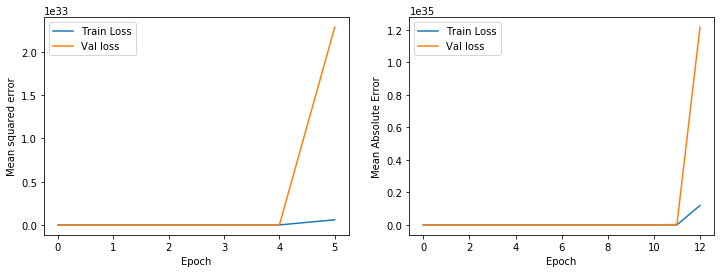

In [14]:
# call model for right number of features
# in addition, we need to decrease the learning rate in this case
# check for yourself what happens for larger learning rates
model_p2r = build_model(X_train_p2.shape[1],L2 = 100.0)
model_p2r.summary()

# Since the learning rate is a factor 10 smaller, we need more EPOCHs to cover the same ground
EPOCHS = 30

# Store training stats per EPOCH in history to allow plotting afterwards
history_p2r = model_p2r.fit(X_train_p2s, r_train, epochs=EPOCHS,
                    validation_data=(X_val_p2s,r_val), verbose=0)
plot_history(history_p2r)

[train_loss_p2r, train_mae_p2r] = model_p2r.evaluate(X_train_p2s, r_train, verbose=0)
print("Training set Mean Squared Error:{:7.2f}".format(train_loss_p2))
print("Training set Mean Absolute Error:{:7.2f}\n".format(train_mae_p2))

[val_loss_p2r, val_mae_p2r] = model_p2r.evaluate(X_val_p2s, r_val, verbose=0)
print("Validation set Mean Squared Error:{:7.2f}".format(val_loss_p2))
print("Validation set Mean Absolute Error:{:7.2f}\n".format(val_mae_p2))

[test_loss_p2r, test_mae_p2r] = model_p2r.evaluate(X_test_p2s, r_test, verbose=0)
print("Test set Mean Squared Error:{:7.2f}".format(test_loss_p2))
print("Test set Mean Absolute Error:{:7.2f}\n".format(test_mae_p2))

You will learn thoughout this course that monitoring train and validation curves is crucial for achieving good results with deep learning. Achieving curves that are quite smooth and have converged far enough should always be your priority before changing anything else. **You can not compare the results for networks that have not properly converged!!** This is done mostly by adapting the learning rate, the batch size and the number of EPOCHS. These parameters can not be tuned once and then kept fixed, since their optimal values depend on many other factors in the network. We will treat this in depth in this course.

**Exercise**: try to achieve a better score with polynomial regression:
- tune the amount of L2 regularisation, the learning rate and the number of epochs for the second degree polynomials
- If that works out, try if you can do better with a third or higher degree polynomial

Don't expect miracles, though: this data set is very noisy!


**Just for the fun of it**
Since you already sort of know that neural networks are essentially stacks of layers, we will show below how to make a deeper model for the original features, which you can then play with.


In [15]:
def build_model_hidden(inp_shape, neurons = 10, lr = 0.01,L2=0.0):
  # a model is always built up as a list of layers
  # In the first layer, you need to define the shape of the input
  # all other layers automatically use the shape of the previous layer's output
  # a linear model only has a single layer

  model = keras.Sequential([
                        keras.layers.Dense(neurons, input_shape=(inp_shape,), activation='relu', kernel_regularizer=regularizers.l2(L2)),
                        keras.layers.Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(L2)),
                        keras.layers.Dense(1, kernel_regularizer=regularizers.l2(L2))
  ])

  optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

  # When compiling the model, you have to tell it which training algorithm we will be using
  # Details about these are not relevant at this point
  # You also need to tell it which loss function it will be optimising 
  # and which alternative loss functions to keep track of
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                140       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________
Training set Mean Squared Error:  21.60
Training set Mean Absolute Error:   3.26

Validation set Mean Squared Error:  22.62
Validation set Mean Absolute Error:   3.39

Test set Mean Squared Error:  26.36
Test set Mean Absolute Error:   3.32



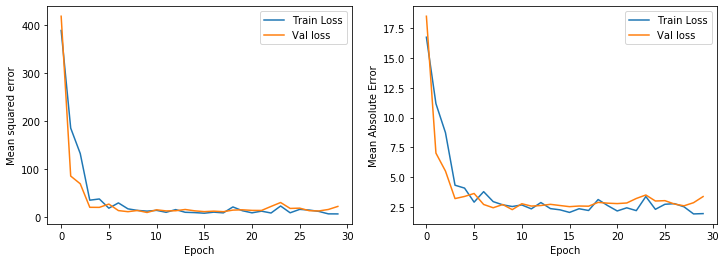

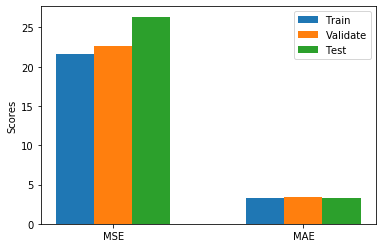

In [16]:
# call model for right number of features
# in addition, we need to decrease the learning rate in this case
# check for yourself what happens for larger learning rates
model_hidden = build_model_hidden(X_train_s.shape[1],lr=0.01,neurons = 10)
model_hidden.summary()

# Since the learning rate is a factor 10 smaller, we need more EPOCHs to cover the same ground
EPOCHS = 30

# Store training stats per EPOCH in history to allow plotting afterwards
history_hidden = model_hidden.fit(X_train_s, r_train, epochs=EPOCHS,
                    validation_data=(X_val_s,r_val), verbose=0)
plot_history(history_hidden)

[train_loss_hidden, train_mae_hidden] = model_hidden.evaluate(X_train_s, r_train, verbose=0)
print("Training set Mean Squared Error:{:7.2f}".format(train_loss_hidden))
print("Training set Mean Absolute Error:{:7.2f}\n".format(train_mae_hidden))

[val_loss_hidden, val_mae_hidden] = model_hidden.evaluate(X_val_s, r_val, verbose=0)
print("Validation set Mean Squared Error:{:7.2f}".format(val_loss_hidden))
print("Validation set Mean Absolute Error:{:7.2f}\n".format(val_mae_hidden))

[test_loss_hidden, test_mae_hidden] = model_hidden.evaluate(X_test_s, r_test, verbose=0)
print("Test set Mean Squared Error:{:7.2f}".format(test_loss_hidden))
print("Test set Mean Absolute Error:{:7.2f}\n".format(test_mae_hidden))

# We'll make a nice plot to visualise this
# Note that this can be done a lot more elegantly, e.g. with Seaborn

train_values = [train_loss_hidden, train_mae_hidden]
val_values = [val_loss_hidden, val_mae_hidden]
test_values = [test_loss_hidden, test_mae_hidden]
labels = ['MSE', 'MAE']


x=np.arange(2)
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_values, width, label='Train')
rects2 = ax.bar(x , val_values, width, label='Validate')
rects3 = ax.bar(x + width, test_values, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
#ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()

## 5. What is different for classification

For classification problems, we have discussed logistic regression as a linear model. If there are only two classes (*binary classification*), a logistic regression model only has one output, wich can take values between 0 and 1. If there are multiple classes, it has one output per class and these outputs sum up to 1. For each output, its structure is the same as that of linear regression, but with a sigmoid nonlinearity at the end. The values before the sigmoids are called the log-likelihood ratios or *logits* (we mention this term here because it sometimes occurs in the tensorflow Keras documentation and example notebooks).

The most commonly used loss functions for classification are:
- For multiple classes: categorical_crossentropy (cce) uses a one-hot array to calculate the probability, in other words, your labels need to be vectors of zeros, with a single 1 for the correct class
- For multiple classes: sparse_categorical_crossentropy (scce) uses a category index, so your labels are numbers (starting at 0, so for 3 classes, they would be 0, 1 or 2)
- For two classes: binary_crossentropy (labels are 0 or 1)

If you use categorical_crossentropy, you will usually have to convert the original class labels to one-hot vectors before starting to train your model and take the maximum afterwards to convert the predictions back into a class number.

If you use sparse_categorical_crossentropy, you will need to convert the model output to probabilities in order to analyse the mistakes your model makes and how certain it is about those mistakes.

Your first and second assignments will be classification problems, and you will recieve a "getting started" notebook each time, so you can focus on tuning networks.

## 6. Where to find more?


There are already quite a few example notebooks on the [Tensorflow Keras website](https://www.tensorflow.org/guide/keras/overview). You should probably use these as a first source of reliable code examples. The documentation on the original Keras website is still much more extensive but not quite up to date for the most recent syntax. Although Tensorflow 2.0 is quite new, tf.keras examples will become available online quickly. **When in doubt: ask us on Slack! **
